## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [47]:
from resources.conv_learner import *
PATH = "datasets/yeast_v2/"
os.makedirs(PATH,exist_ok=True)

In [ ]:
# sys.modules.keys()

In [3]:
classes = ('WT', 'mfb1KO')
stats = (np.array([0.02171638, 0.00451]), np.array([0.0016155,  0.00146062])) #calculated for yeast_v2
# stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [81]:
def get_data(sz,bs):
#     tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [82]:
bs=140

### Look at data

In [83]:
data = get_data(200,4)

In [84]:
x,y=next(iter(data.trn_dl))

In [ ]:
print(x.shape)

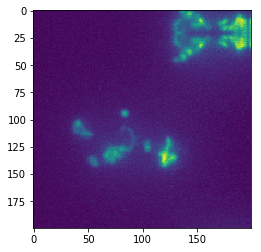

In [90]:
plt.imshow(data.trn_ds.denorm(x)[3,:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

## Fully connected model

In [9]:
data = get_data(200,bs)

In [10]:
lr=1e-5

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [11]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [12]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40,2]), data) #(!) change channel-number & classes accordingly

In [13]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=80000, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=2, bias=True)
   )
 ), [3200000, 40, 80, 2])

In [14]:
learn.summary()

(OrderedDict([('Linear-1',
               OrderedDict([('input_shape', [-1, 80000]),
                            ('output_shape', [-1, 40]),
                            ('trainable', True),
                            ('nb_params', 3200040)])),
              ('Linear-2',
               OrderedDict([('input_shape', [-1, 40]),
                            ('output_shape', [-1, 2]),
                            ('trainable', True),
                            ('nb_params', 82)]))]),
 Variable containing:
 -0.6818 -0.7046
 -0.6935 -0.6928
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [ ]:
learn.lr_find2()

In [ ]:
learn.sched.plot()

In [ ]:
%time learn.fit(lr, 2)

In [18]:
%time learn.fit(lr, 200, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                                                    
    0      0.547346   0.668248   0.642857  
    1      0.547067   0.668251   0.642857                                                                                                                                                                                                    
    2      0.546477   0.66838    0.642857                                                                                                                                                                                                    
    3      0.545625   0.668605   0.642857                                                                                                                                                                                                    
    

    34     0.483062   0.675866   0.585714                                                                                                                                                                                                    
    35     0.480675   0.676241   0.585714                                                                                                                                                                                                    
    36     0.478288   0.676637   0.585714                                                                                                                                                                                                    
    37     0.475895   0.677075   0.585714                                                                                                                                                                                                    
    38     0.473505   0.677394   0.585714       

    68     0.405234   0.691344   0.628571                                                                                                                                                                                                    
    69     0.403107   0.6918     0.628571                                                                                                                                                                                                    
    70     0.400999   0.69233    0.628571                                                                                                                                                                                                    
    71     0.398913   0.692815   0.628571                                                                                                                                                                                                    
    72     0.396834   0.693281   0.628571       

   102     0.340103   0.707304   0.657143                                                                                                                                                                                                    
   103     0.338412   0.707721   0.657143                                                                                                                                                                                                    
   104     0.33673    0.708203   0.657143                                                                                                                                                                                                    
   105     0.335063   0.708698   0.657143                                                                                                                                                                                                    
   106     0.333405   0.709196   0.657143       

   136     0.288799   0.722994   0.614286                                                                                                                                                                                                    
   137     0.287475   0.723468   0.614286                                                                                                                                                                                                    
   138     0.28616    0.723973   0.614286                                                                                                                                                                                                    
   139     0.284857   0.724421   0.614286                                                                                                                                                                                                    
   140     0.283558   0.724879   0.614286       

   170     0.24889    0.738046   0.6                                                                                                                                                                                                         
   171     0.247862   0.738491   0.6                                                                                                                                                                                                         
   172     0.246838   0.73887    0.6                                                                                                                                                                                                         
   173     0.245819   0.739253   0.6                                                                                                                                                                                                         
   174     0.24481    0.739692   0.6            

[array([0.75021]), 0.6142857074737549]

In [16]:
learn.sched.plot()

AttributeError: 'CosAnneal' object has no attribute 'plot'

## CNN

In [38]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [40]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 2), data)

### .from_model_data triggers basicmodel() which forwards to a pytorch's .cuda function to run model on GPU. Hence 
### an explicit model.cuda is not necessary here.

In [41]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

(OrderedDict([('Conv2d-1',
               OrderedDict([('input_shape', [-1, 2, 200, 200]),
                            ('output_shape', [-1, 20, 99, 99]),
                            ('trainable', True),
                            ('nb_params', 380)])),
              ('Conv2d-2',
               OrderedDict([('input_shape', [-1, 20, 99, 99]),
                            ('output_shape', [-1, 40, 49, 49]),
                            ('trainable', True),
                            ('nb_params', 7240)])),
              ('Conv2d-3',
               OrderedDict([('input_shape', [-1, 40, 49, 49]),
                            ('output_shape', [-1, 80, 24, 24]),
                            ('trainable', True),
                            ('nb_params', 28880)])),
              ('AdaptiveMaxPool2d-4',
               OrderedDict([('input_shape', [-1, 80, 24, 24]),
                            ('output_shape', [-1, 80, 1, 1]),
                            ('nb_params', 0)])),
              ('Linear

In [ ]:
learn.lr_find(end_lr=100)

In [ ]:
learn.sched.plot()

In [ ]:
%time learn.fit(1e-5, 2)

In [42]:
%time learn.fit(1e-5, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                                                    
    0      0.731819   0.718615   0.514286  
    1      0.731671   0.718472   0.514286                                                                                                                                                                                                    
    2      0.731584   0.71827    0.514286                                                                                                                                                                                                    
    3      0.731385   0.718003   0.514286                                                                                                                                                                                                    

Wal

[array([0.718]), 0.5142857432365417]

## Refactored

In [21]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [22]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 2), data)

In [ ]:
learn.summary()

In [ ]:
%time learn.fit(1e-1, 2)

In [ ]:
%time learn.fit(1e-1, 2, cycle_len=1)

## BatchNorm

In [92]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [93]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2) #(!) changed 3 to 2
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [94]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 2), data)

In [95]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 40, 50, 50]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
           

In [ ]:
%time learn.fit(3e-2, 2)

In [101]:
%time learn.fit(1e-4, 20, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                                                    
    0      0.220459   0.261132   0.871429  
    1      0.228237   0.255958   0.857143                                                                                                                                                                                                    
    2      0.229293   0.24755    0.885714                                                                                                                                                                                                    
    3      0.217468   0.258514   0.857143                                                                                                                                                                                                    
    

[array([0.3634]), 0.8428571428571429]

In [100]:
learn.save('tmp_batchNorm_aug')

## Deep BatchNorm

In [ ]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [ ]:
%time learn.fit(1e-2, 2)

In [ ]:
%time learn.fit(1e-2, 2, cycle_len=1)

## Resnet

In [34]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [35]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [36]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 2), data)

In [30]:
wd=1e-5

In [33]:
%time learn.fit(1e-5, 2, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-5, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [37]:
%time learn.fit(1e-5, 20, cycle_len=4, wds=wd)

  0%|                                                                                                                                                                                                                  | 0/2 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight[10, 3, 5, 5], so expected input[140, 2, 200, 200] to have 3 channels, but got 2 channels instead

## Resnet 2

In [31]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [ ]:
wd=1e-6

In [ ]:
%time learn.fit(1e-2, 2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.save('tmp4_clr')

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [ ]:
metrics.log_loss(y,preds), accuracy(preds,y)

In [ ]:
metrics.log_loss(y,preds)

### End